<h1>Wasserstein GAN</h1>

#Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import os
import time
from IPython import display
from tensorflow import keras
from tensorflow.keras import layers
tf.__version__

'2.18.0'

# load and process dataset

In [2]:
(X_treinamento, y_treinamento), (_, _) = tf.keras.datasets.mnist.load_data()

In [3]:
X_treinamento.shape, y_treinamento.shape

((60000, 28, 28), (60000,))

In [4]:
X_treinamento = X_treinamento.reshape(X_treinamento.shape[0], 28, 28, 1).astype('float32')

In [5]:
X_treinamento = (X_treinamento - 127.5) / 127.5 # redimensionar os pixels para -1 e 1

In [6]:
buffer_size = y_treinamento.shape[0] #60000
batch_size = 256

X_treinamento = tf.data.Dataset.from_tensor_slices(X_treinamento).shuffle(buffer_size).batch(batch_size)

#Generator


utilizando a mesma arquitetura utilizada nos outros projetos com DCGAN (Deep Convolutional Generative Augmented Network)

In [7]:
def cria_gerador():
  network = tf.keras.Sequential()

  network.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,))) # (100,)a virgula transforme em tupla
  network.add(layers.BatchNormalization())
  network.add(layers.LeakyReLU())

  network.add(layers.Reshape((7,7,256)))

  #7x7x128
  network.add(layers.Conv2DTranspose(filters=128,
                                     kernel_size=(5,5),
                                     padding='same',
                                     use_bias=False))
  network.add(layers.BatchNormalization())
  network.add(layers.LeakyReLU())

  #14x14x64
  network.add(layers.Conv2DTranspose(filters=64,
                                     kernel_size=(5,5),
                                     strides=(2,2),
                                     padding='same',
                                     use_bias=False))
  network.add(layers.BatchNormalization())
  network.add(layers.LeakyReLU())

  #28x28x1
  network.add(layers.Conv2DTranspose(filters=1,
                                     kernel_size=(5,5),
                                     strides=(2,2),
                                     padding='same',
                                     use_bias=False,
                                     activation='tanh'))
  network.summary()
  return network


In [8]:
gerador = cria_gerador()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 12544)          │     1,254,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 12544)          │        50,176 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 7, 7, 128)      │       819,200 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 7, 7, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 14, 14, 64)     │       204,800 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 28, 28, 1)      │         1,600 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,330,944 (8.89 MB)

 Trainable params: 2,305,472 (8.79 MB)

 Non-trainable params: 25,472 (99.50 KB)

In [9]:
gerador.inputs

[<KerasTensor shape=(None, 100), dtype=float32, sparse=False, name=keras_tensor>]

In [10]:
ruido = tf.random.normal([1,100])
print(ruido)

tf.Tensor(
[[ 0.4128187  -0.6791817   0.00678082  0.63742095 -0.5948406   0.8050981
   1.0965368   2.3263257  -1.1736691   0.34929332  1.6100982   0.34013602
   0.6443459   1.8091178  -1.6057702  -0.5501504  -0.21856509 -0.70442045
  -0.8845068  -0.38046518 -1.2852032   1.5622631   1.2111822  -0.35121083
  -2.3826408   1.9373946   0.9753364   0.9262979   0.6695921  -0.5349619
  -0.7354821  -0.95091003 -1.8331786  -1.4758306  -0.47153643  0.4118511
   1.3049525   1.1603099  -0.23467891  2.0532105  -0.96296793 -0.24077149
   0.12845701  1.5595767   0.08029282 -1.7835253   0.01028467 -1.3486532
  -1.4826403  -1.7470409   0.2853752  -1.141403   -0.0725107  -0.34657797
   1.5930923  -1.3620245  -0.97145194 -0.9112823  -1.5705961   3.248038
  -1.4274285   1.0448463  -0.13759771 -0.44837198  1.8624746  -0.91291326
  -0.31942692 -0.01495572  0.15952712  0.3472922  -1.3601292  -0.13570288
  -1.2251664  -0.6488743   0.4581421  -1.8992343  -0.13164866 -1.026168
   0.99740547 -0.81920755 -0.853850

(1, 28, 28, 1)


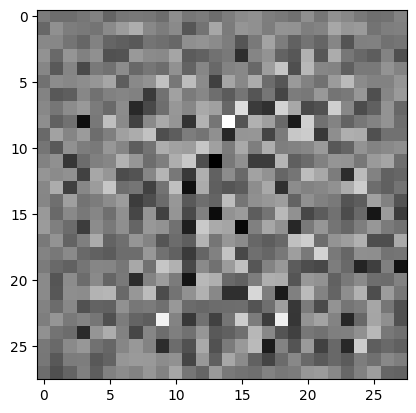

In [11]:
imagem_gerada = gerador(ruido, training = False)
print(imagem_gerada.shape)

plt.imshow(imagem_gerada[0, :, :, 0], cmap='gray')

#Discriminator (Or Critic in WGANs)

In [12]:
def cria_discriminador():
  network = tf.keras.Sequential()

  #14x14x64
  network.add(layers.Conv2D(64, (5,5), strides=(2,2), padding='same', input_shape=[28,28,1]))
  network.add(layers.LeakyReLU())
  network.add(layers.Dropout(0.3))

  #7x7x128
  network.add(layers.Conv2D(128, (5,5), strides=(2,2), padding='same'))
  network.add(layers.LeakyReLU())
  network.add(layers.Dropout(0.3))

  # 28x28x1 -> transforma em um único vetor conectado a um neuronio
  network.add(layers.Flatten())
  network.add(layers.Dense(1))

  network.summary()
  return network


In [13]:
discriminador = cria_discriminador()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 14, 14, 64)     │         1,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 7, 7, 128)      │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │         6,273 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 212,865 (831.50 KB)

 Trainable params: 212,865 (831.50 KB)

 Non-trainable params: 0 (0.00 B)

In [14]:
discriminador.inputs

[<KerasTensor shape=(None, 28, 28, 1), dtype=float32, sparse=False, name=keras_tensor_67>]

In [15]:
resultado = discriminador(imagem_gerada)
print(resultado) #resultado em logit

tf.Tensor([[0.00065774]], shape=(1, 1), dtype=float32)


#Funções de perda de Wasserstein Loss

A loss é a diferença entre o valor esperado da saída do discriminador para imagens autênticas e o valor esperado do discriminador para imagens geradas. O objetivo do discriminador é maximizar essa diferença, enquanto do gerador é minimizar.
Deve-se criar o cálculo de loss para monitorar os estágios do treinamento.


In [16]:
tf.math.reduce_mean([0.2,0.9, 0.95]) # é retornada a médiad os valores

<tf.Tensor: shape=(), dtype=float32, numpy=0.6833333373069763>

In [17]:
def loss_gerador(fake_saida):
  return -tf.reduce_mean(fake_saida)

In [18]:
def loss_discriminador(real_saida, fake_saida, gradient_penalty): #lembrando que é uma WGAN GP
  c_lambda = 10
  #o objetivo do discriminador é maximizar essa diferença
  d_loss = tf.math.reduce_mean(fake_saida) - tf.math.reduce_mean(real_saida) + c_lambda * gradient_penalty

  return d_loss

#Gradient Penalty

Para usar a perda de Wasserstein, nosso discriminador precisa ser 1-L (1-Lipschitz) continuo, ou seja, a norma do gradiente deve ser no máximo 1 em cada ponto.
Para impor a continuidade de 1-L usaremos o conceito de Gradient Penalty.

O uso de GP na WGAN penaliza a norma de gradiente do critico (discriminador) considerando a sua entrada. Esse método proposto tem um desempenho melhor do que o WGAN normal e permite o treinamento estável de uma ampla variedade de GAN.

É chamado de WGAN-GP.

Para calcular o gradient penalty:

1. Calcular uma imagem interpolada da imagem real e fake ((real_image * epsilon + fake_image*(1- epsilon)))
2. Calcular o gradiente da saída do discriminador em relação à imagem interpolada. Depois disso, calcular a norma do gradiente.
3. Por fim, a penalidade é calculada como uma média do quadrado de (norma -1), pois queremos que a norma seja próxima de um.

Para trabalhar com operações envolvendo gradiente usa-se GradientTape()

In [19]:
@tf.function
def gradient_penalty(real, fake, epsilon):
  imgs_interpoladas = real * epsilon + fake * (1-epsilon)
  with tf.GradientTape() as gp_tape:
    #1. Calcular uma imagem interpolada da imagem real e fake
    gp_tape.watch(imgs_interpoladas)
    scores = discriminador(imgs_interpoladas)

  #2. Calcular o gradiente da saída do discriminador em relação à imagem interpolada. Depois disso, calcular a norma do gradiente.
  grads = gp_tape.gradient(scores, imgs_interpoladas)[0]
  gradient_norm = tf.norm(grads)

  #3. calcular a penalidade
  gp = tf.math.reduce_mean((gradient_norm - 1)**2)
  return gp

In [20]:
gerador_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5, beta_2=0.9)
discriminador_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5, beta_2=0.9)

In [21]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefixo = os.path.join(checkpoint_dir, "checkpoints")
checkpoint = tf.train.Checkpoint(gerador_optimizer=gerador_optimizer,
                                 discriminador_optimizer=discriminador_optimizer,
                                 gerador=gerador,
                                 discriminador=discriminador)

# Treinamento da GAN e visualização dos resultados

In [22]:
epochs = 30
noise_dim = 100
num_amostras = 16
seed = tf.random.normal([num_amostras, noise_dim])

In [23]:
seed

<tf.Tensor: shape=(16, 100), dtype=float32, numpy=
array([[ 1.6797218 ,  0.1918887 , -0.15991779, ..., -2.2763987 ,
        -0.9748017 , -0.18548186],
       [ 0.09126399,  0.07285495,  0.44880858, ...,  1.4848943 ,
         1.4968784 ,  1.2676669 ],
       [ 0.23259734, -0.006071  ,  0.9095421 , ...,  0.05490801,
        -0.10067838,  0.26085153],
       ...,
       [ 1.8908601 , -0.58514494,  0.4360869 , ...,  1.1063992 ,
        -1.805712  ,  1.1853503 ],
       [ 0.96231633, -0.25838557, -0.1697265 , ...,  1.0623697 ,
         1.5240493 ,  0.19628255],
       [-0.04885826,  2.393185  ,  1.4549971 , ...,  0.5624194 ,
         0.41235566, -1.4488373 ]], dtype=float32)>

In [24]:
def etapa_treinamento(imgs):
  noise = tf.random.normal([batch_size, noise_dim])
  #diferente da dcgan, na wgan o discriminador é treinado multiplas vezes por etapa
  discriminador_etapas_extras = 3
  for i in range(discriminador_etapas_extras):
    with tf.GradientTape() as disc_tape:
      fake_imgs = gerador(noise, training=True) #teremos as imagens geradas e realizaremos o treino
      real_saida = discriminador(imgs, training=True) # entrada imagens reais, saida logits
      fake_saida = discriminador(fake_imgs, training=True) # entrada imagens geradas, saidas logits
      epsilon = tf.random.uniform([batch_size, 1, 1, 1], 0, 1)
      gp = gradient_penalty(imgs, fake_imgs, epsilon)

      d_loss = loss_discriminador(real_saida, fake_saida, gp)

    discriminador_gradients = disc_tape.gradient(d_loss, discriminador.trainable_variables) # indica qual direção atualizar os pesos
    discriminador_optimizer.apply_gradients(zip(discriminador_gradients, discriminador.trainable_variables)) # altera os pesos
    #aqui será executado o treinamento 3x

  with tf.GradientTape() as gen_tape:
    fake_imgs = gerador(noise, training=True)
    fake_saida = discriminador(fake_imgs, training=True) # obtem_se os logits de imagens falsas
    g_loss = loss_gerador(fake_saida) # passamos os logits de imgs falsas para receber a loss

  gerador_gradients = gen_tape.gradient(g_loss, gerador.trainable_variables)
  gerador_optimizer.apply_gradients(zip(gerador_gradients, gerador.trainable_variables))
  return d_loss, g_loss

In [25]:
def gerar_e_salvar_imgs(model, epoch, test_input):
  preds = model(test_input, training=False)
  fig = plt.figure(figsize=(4,4))
  for i in range(preds.shape[0]):
    plt.subplot(4, 4, i+1) #4 linhas, 4 colunas e id no gráfico
    plt.imshow(preds[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
    plt.axis('off')
  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch)) # uma imagem por época
  plt.show()

In [26]:
def treinar(dataset,epochs):
  for epoch in range(epochs):
    inicio = time.time()
    for img_batch in dataset:
      if len(img_batch) == batch_size:
        etapa_treinamento(img_batch)
    # display.clear_output(wait = True) isso faria mostrar apenas o último resultado
    gerar_e_salvar_imgs(gerador, epoch + 1, seed)
    if(epoch + 1) %10 == 0:
      checkpoint.save(file_prefix = checkpoint_prefixo)
    print('Tempo para processar época {} foi de {} segundos'.format(epoch + 1, time.time() - inicio))

  #depois do for salvamos a imgs

  display.clear_output(wait=True)
  gerar_e_salvar_imgs(gerador, epochs, seed)
  gerador.save('gerador.h5')


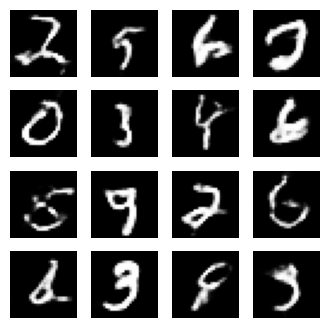

In [27]:
treinar(X_treinamento, epochs)

In [28]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

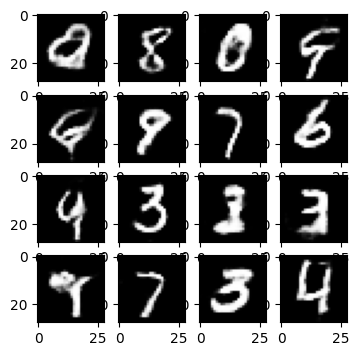

In [29]:
#vamos realizar um teste carregando o checkpoint
seed_input = tf.random.normal([num_amostras, noise_dim])
preds = gerador(seed_input, training = False)
fig = plt.figure(figsize=(4,4))

for i in range(preds.shape[0]):
  plt.subplot(4, 4, i+1) #4 linhas, 4 colunas e id no gráfico
  plt.imshow(preds[i, :, :, 0] * 127.5 + 127.5, cmap='gray')

Mais implementações para estudo:

https://github.com/robbiebarrat/art-DCGAN
https://github.com/tdrussell/IllustrationGAN
https://github.com/viuts/wgan-animefaces